In [309]:
# --- Importe suas classes ---
# (Assumindo que estão no PYTHONPATH ou na mesma pasta)
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import HybridCQN 
from method.qnn import QuantumNeuralNetwork
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
import torch.nn as nn
import numpy as np
import json


from utils.save import *



In [310]:
# =============================================================================
# 0. CONFIGURAÇÃO
# =============================================================================

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'mean_last_100_loss' # ou 'mean_last_100_loss'

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0

In [311]:
# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================

all_dfs = []
summary = [SUMMARY_CLASSIC_PATH, SUMMARY_HYBRID_PATH, SUMMARY_QUANTUM_PATH, SUMMARY_CQUANTUM_PATH, SUMMARY_CHYBRID_PATH]

for summar in summary:
    all_dfs.append(pd.read_csv(summar))


df_all = pd.concat(all_dfs, ignore_index=True)

valid_seeds = [1924, 1925, 1926, 1973, 2025, 2024, 2012, 1958, 1962, 1997]
df_all = df_all[
    (df_all["seed"].isin(valid_seeds))  # filtragem pelas seeds
]

In [312]:
df_class = df_all[
    (df_all["model_type"] == "MLP") &
    (df_all["hidden"].isin([2, 3, 5, 10, 20])) &
    (df_all["blocks"].isin([1, 2, 3, 5, 10]))
    ].drop_duplicates()

df_class = df_class.drop_duplicates(subset=["hidden", "blocks", "seed"])

df_hybrid = df_all[
    (df_all["model_type"] == "HQNN") &
    #(df_all["n_qubits"] == 4) &
    (df_all["entangler"] == "basic")
    ].drop_duplicates()     

In [313]:
df_hybrid

,model_type,run_id_prefix,lr,epochs,activation,hidden,blocks,seed,run_id,mse_teste_normalizado,...,model_path,loss_history_path,final_total_loss,mean_last_100_loss,model_class,entangler,n_qubits,n_layers,k,n_vertex
484,HQNN,hqnn_basic_mlp,0.002,15000,Tanh(),3.0,1.0,1924,hqnn_basic_mlp_n_3_b_1_n_qubits_2_n_l_1_seed_1924,0.000016,...,experimentos_pinn/modelos_salvos/modelo_hqnn_b...,experimentos_pinn/historicos_loss/loss_hqnn_ba...,0.000022,0.000022,MLP,basic,2.0,1.0,NaN,NaN
485,HQNN,hqnn_basic_mlp,0.002,15000,Tanh(),3.0,1.0,1925,hqnn_basic_mlp_n_3_b_1_n_qubits_2_n_l_1_seed_1925,0.000095,...,experimentos_pinn/modelos_salvos/modelo_hqnn_b...,experimentos_pinn/historicos_loss/loss_hqnn_ba...,0.000125,0.000128,MLP,basic,2.0,1.0,NaN,NaN
486,HQNN,hqnn_basic_mlp,0.002,15000,Tanh(),3.0,1.0,1926,hqnn_basic_mlp_n_3_b_1_n_qubits_2_n_l_1_seed_1926,0.000087,...,experimentos_pinn/modelos_salvos/modelo_hqnn_b...,experimentos_pinn/historicos_loss/loss_hqnn_ba...,0.000115,0.000118,MLP,basic,2.0,1.0,NaN,NaN
487,HQNN,hqnn_basic_mlp,0.002,15000,Tanh(),3.0,1.0,1924,hqnn_basic_mlp_n_3_b_1_n_qubits_2_n_l_2_seed_1924,0.000081,...,experimentos_pinn/modelos_salvos/modelo_hqnn_b...,experimentos_pinn/historicos_loss/loss_hqnn_ba...,0.000107,0.000107,MLP,basic,2.0,2.0,NaN,NaN
488,HQNN,hqnn_basic_mlp,0.002,15000,Tanh(),3.0,1.0,1925,hqnn_basic_mlp_n_3_b_1_n_qubits_2_n_l_2_seed_1925,0.000060,...,experimentos_pinn/modelos_salvos/modelo_hqnn_b...,experimentos_pinn/historicos_loss/loss_hqnn_ba...,0.000083,0.000083,MLP,basic,2.0,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,HQNN,hqnn_basic_mlp,0.002,15000,Tanh(),3.0,1.0,1997,hqnn_basic_mlp_n_3_b_1_n_qubits_7_n_l_1_seed_1997,0.000017,...,experimentos_pinn/modelos_salvos/modelo_hqnn_b...,experimentos_pinn/historicos_loss/loss_hqnn_ba...,0.000023,0.000027,MLP,basic,7.0,1.0,NaN,NaN
845,HQNN,hqnn_basic_mlp,0.002,15000,Tanh(),3.0,1.0,1924,hqnn_basic_mlp_n_3_b_1_n_qubits_7_n_l_3_seed_1924,0.000015,...,experimentos_pinn/modelos_salvos/modelo_hqnn_b...,experimentos_pinn/historicos_loss/loss_hqnn_ba...,0.000022,0.000022,MLP,basic,7.0,3.0,NaN,NaN
846,HQNN,hqnn_basic_mlp,0.002,15000,Tanh(),3.0,1.0,1925,hqnn_basic_mlp_n_3_b_1_n_qubits_7_n_l_3_seed_1925,0.000049,...,experimentos_pinn/modelos_salvos/modelo_hqnn_b...,experimentos_pinn/historicos_loss/loss_hqnn_ba...,0.000072,0.000073,MLP,basic,7.0,3.0,NaN,NaN
847,HQNN,hqnn_basic_mlp,0.002,15000,Tanh(),3.0,1.0,1926,hqnn_basic_mlp_n_3_b_1_n_qubits_7_n_l_3_seed_1926,0.000017,...,experimentos_pinn/modelos_salvos/modelo_hqnn_b...,experimentos_pinn/historicos_loss/loss_hqnn_ba...,0.000026,0.000023,MLP,basic,7.0,3.0,NaN,NaN


In [314]:
df_class.groupby(["hidden", "blocks", "seed"]).size()


hidden  blocks  seed
2.0     1.0     1924    1
                1925    1
                1926    1
                1958    1
                1962    1
                       ..
20.0    10.0    1973    1
                1997    1
                2012    1
                2024    1
                2025    1
Length: 250, dtype: int64

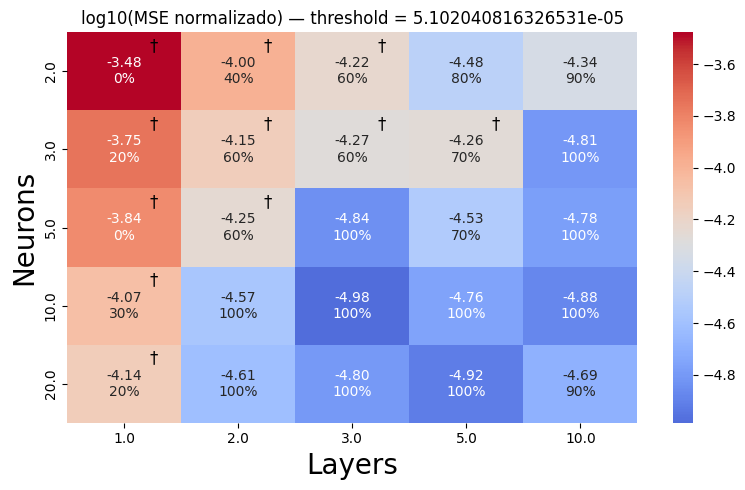

In [315]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

threshold = (1 / 140**2)

# =======================
# 1) Tabela com a MÉDIA
# =======================
pivot = df_class.pivot_table(
    index="hidden",
    columns="blocks",
    values=LOSS_COLUMN,
    aggfunc="mean"
)

# log10 dos valores
pivot_log = np.log10(pivot)

# =======================
# 2) Tabela com % de CONVERGÊNCIA
#    (fração de runs com loss < threshold)
# =======================
conv_pivot = (
    df_class
    .groupby(["hidden", "blocks"])[LOSS_COLUMN]
    .apply(lambda x: 100 * np.mean(x < threshold))
    .unstack("blocks")
)

# =======================
# 3) Matriz de strings para o annot
#    "valor\nXX%"
# =======================
annot = np.empty_like(pivot_log.values, dtype=object)

for i, h in enumerate(pivot.index):
    for j, b in enumerate(pivot.columns):
        val = pivot_log.loc[h, b]
        conv = conv_pivot.loc[h, b] if (h in conv_pivot.index and b in conv_pivot.columns) else np.nan
        if np.isnan(conv):
            annot[i, j] = f"{val:.2f}\n-"
        else:
            annot[i, j] = f"{val:.2f}\n{conv:.0f}%"

# log10 do threshold para centralizar o mapa
thr_log = np.log10(threshold)

plt.figure(figsize=(8,5))
ax = sns.heatmap(
    pivot_log,
    annot=annot,
    fmt="",              # importante: usamos strings prontas
    cmap="coolwarm",
    center=thr_log,
)

plt.title(f"log10(MSE normalizado) — threshold = {threshold}")
plt.ylabel("Neurons", fontsize=20)
plt.xlabel("Layers", fontsize=20)

# === adicionar '†' no canto superior direito das células acima do threshold ===
for i in range(pivot.shape[0]):        # linhas
    for j in range(pivot.shape[1]):    # colunas
        if pivot.iloc[i, j] > threshold:
            ax.text(
                j + 0.72,   # x deslocado para o canto superior direito
                i + 0.25,   # y deslocado levemente para cima
                "$\\dagger$",
                color="black",
                fontsize=12,
                fontweight="bold"
            )

plt.tight_layout()
plt.show()


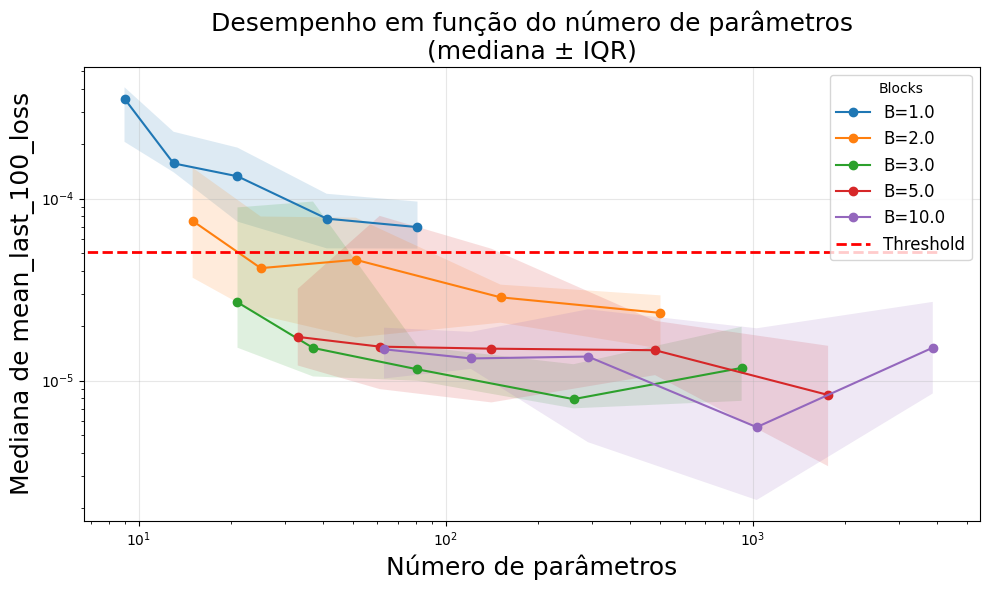

In [316]:
# ======================================================
# 1) AGRUPAMENTO POR (blocks, num_params)
#    -> mediana
#    -> IQR (Q1 e Q3)
# ======================================================

df_stats = df_class.groupby(["blocks", "num_params"])[LOSS_COLUMN].agg(
    median = "median",
    q1     = lambda x: np.percentile(x, 25),
    q3     = lambda x: np.percentile(x, 75)
).reset_index()

# limites inferior/superior da banda
df_stats["lower"] = df_stats["q1"]
df_stats["upper"] = df_stats["q3"]

# evitar valores negativos em escala log
df_stats["lower"] = df_stats["lower"].clip(lower=1e-12)


# ======================================================
# 2) PLOT — cada valor de blocks vira uma linha
# ======================================================

plt.figure(figsize=(10,6))

blocks_values = sorted(df_stats["blocks"].unique())

for L in blocks_values:
    sub = df_stats[df_stats["blocks"] == L].sort_values("num_params")

    x = sub["num_params"].values
    y = sub["median"].values
    low = sub["lower"].values
    upp = sub["upper"].values

    # linha + banda IQR
    plt.plot(x, y, marker="o", label=f"B={L}")
    plt.fill_between(x, low, upp, alpha=0.15)

xmin, xmax = plt.xlim()

plt.hlines(
    y=threshold,
    xmin=xmin,
    xmax=xmax,
    colors='r',
    linestyles='--',
    linewidth=2,
    label='Threshold'
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Número de parâmetros", fontsize=18)
plt.ylabel(f"Mediana de {LOSS_COLUMN}", fontsize=18)
plt.title("Desempenho em função do número de parâmetros\n(mediana ± IQR)", fontsize=18)
plt.legend(title="Blocks", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


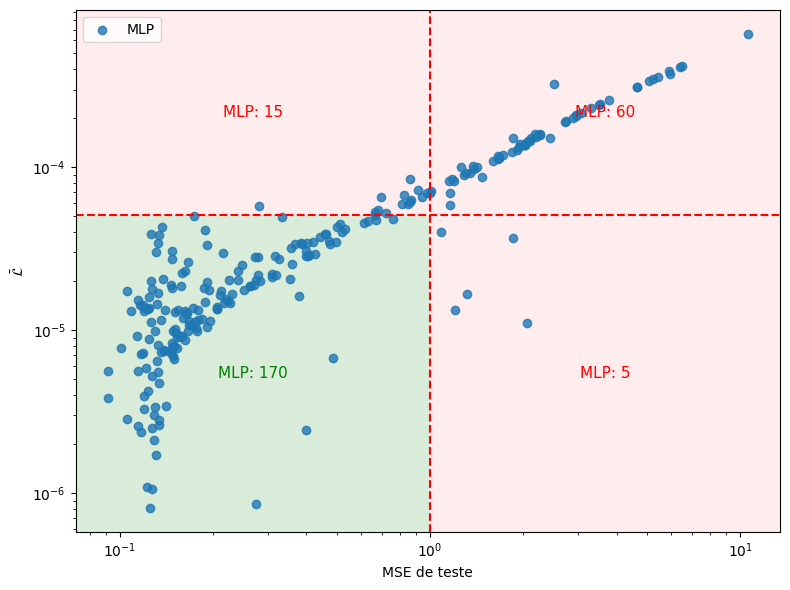

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ==========================
# CONFIGURAÇÕES
# ==========================
MSE_COLUMN = "mse_teste_desnormalizado"   # ajuste se o nome for outro
# LOSS_COLUMN já deve estar definido no seu código

# threshold em x e y
tx = 1.0                    # threshold em MSE
ty = 1 / 140**2             # threshold em loss

# -----------------------------
# dados: um único modelo (df_class)
# -----------------------------
x = df_class[MSE_COLUMN].values
y = df_class[LOSS_COLUMN].values

# -----------------------------
# função p/ contagem de quadrantes
# -----------------------------
def quadrant_counts(x, y, tx, ty):
    x = np.asarray(x); y = np.asarray(y)
    return {
        "Q1": np.sum((x >= tx) & (y >= ty)),  # cima-direita
        "Q2": np.sum((x <  tx) & (y >= ty)),  # cima-esquerda
        "Q3": np.sum((x <  tx) & (y <  ty)),  # baixo-esquerda (região boa)
        "Q4": np.sum((x >= tx) & (y <  ty)),  # baixo-direita
    }

cnt = quadrant_counts(x, y, tx, ty)

# -----------------------------
# plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, label="MLP", alpha=0.8)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("MSE de teste")
ax.set_ylabel(r"$\bar{\mathcal{L}}$")

# linhas de threshold
ax.axhline(ty, color='red', linestyle='--', linewidth=1.5)
ax.axvline(tx, color='red', linestyle='--', linewidth=1.5)

# limites (depois de plottar e setar log!)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# -----------------------------
# quadrantes com Rectangle
# -----------------------------
# quadrante bom (baixo-esquerda) – verde
ax.add_patch(Rectangle(
    (x_min, y_min),           # canto inferior esquerdo
    tx - x_min,               # largura
    ty - y_min,               # altura
    facecolor='green', alpha=0.15, zorder=0
))

# cima-esquerda – vermelho claro
ax.add_patch(Rectangle(
    (x_min, ty),
    tx - x_min,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# baixo-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, y_min),
    x_max - tx,
    ty - y_min,
    facecolor='red', alpha=0.07, zorder=0
))

# cima-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, ty),
    x_max - tx,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# garantir que limites não mudem
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# -----------------------------
# posições dos textos (meio geométrico em log)
# -----------------------------
def mid_log(a, b):
    return 10**((np.log10(a) + np.log10(b)) / 2)

xL = mid_log(x_min, tx)
xR = mid_log(tx,   x_max)
yB = mid_log(y_min, ty)
yT = mid_log(ty,    y_max)

# baixo-esquerda (Q3) – verde (região boa)
ax.text(
    xL, yB,
    f"MLP: {cnt['Q3']}",
    color='green', fontsize=11, ha='center', va='center'
)

# cima-esquerda (Q2) – vermelho
ax.text(
    xL, yT,
    f"MLP: {cnt['Q2']}",
    color='red', fontsize=11, ha='center', va='center'
)

# baixo-direita (Q4) – vermelho
ax.text(
    xR, yB,
    f"MLP: {cnt['Q4']}",
    color='red', fontsize=11, ha='center', va='center'
)

# cima-direita (Q1) – vermelho
ax.text(
    xR, yT,
    f"MLP: {cnt['Q1']}",
    color='red', fontsize=11, ha='center', va='center'
)

ax.legend()
plt.tight_layout()
plt.show()


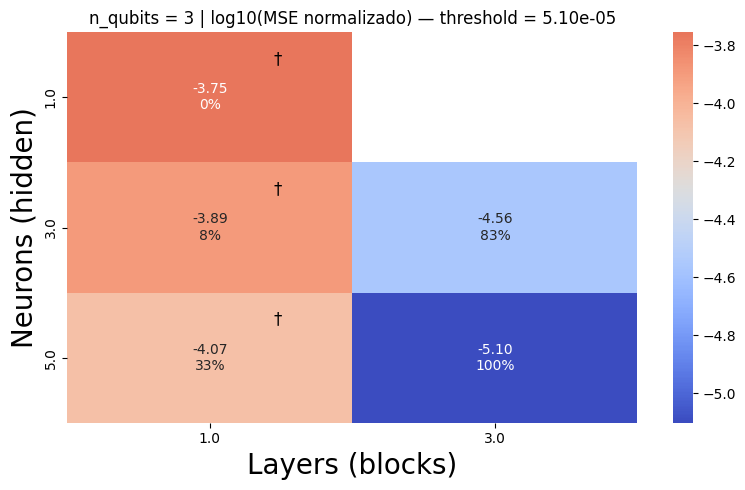

In [318]:
nq_fix = 3   # por exemplo
threshold = (1 / 140**2)

# =======================
# 1) Filtra só esse número de qubits
# =======================
df_q = df_hybrid[df_hybrid["n_qubits"] == nq_fix].copy()

# =======================
# 2) Tabela com a MÉDIA
# =======================
pivot = df_q.pivot_table(
    index="hidden",
    columns="blocks",
    values=LOSS_COLUMN,
    aggfunc="mean"
)

pivot_log = np.log10(pivot)

# =======================
# 3) % de CONVERGÊNCIA (por hidden, blocks)
# =======================
conv_pivot = (
    df_q
    .groupby(["hidden", "blocks"])[LOSS_COLUMN]
    .apply(lambda x: 100 * np.mean(x < threshold))
    .unstack("blocks")
)

# =======================
# 4) Matriz de strings "log10\nXX%"
# =======================
annot = np.empty_like(pivot_log.values, dtype=object)

for i, h in enumerate(pivot.index):
    for j, b in enumerate(pivot.columns):
        val = pivot_log.loc[h, b]
        conv = (
            conv_pivot.loc[h, b]
            if (h in conv_pivot.index and b in conv_pivot.columns)
            else np.nan
        )
        if np.isnan(conv):
            annot[i, j] = f"{val:.2f}\n-"
        else:
            annot[i, j] = f"{val:.2f}\n{conv:.0f}%"

thr_log = np.log10(threshold)

plt.figure(figsize=(8,5))
ax = sns.heatmap(
    pivot_log,
    annot=annot,
    fmt="",
    cmap="coolwarm",
    center=thr_log,
)

plt.title(f"n_qubits = {nq_fix} | log10(MSE normalizado) — threshold = {threshold:.2e}")
plt.ylabel("Neurons (hidden)", fontsize=20)
plt.xlabel("Layers (blocks)", fontsize=20)

# marcar células acima do threshold com † (opcional)
for i in range(pivot.shape[0]):        # linhas
    for j in range(pivot.shape[1]):    # colunas
        if pivot.iloc[i, j] > threshold:
            ax.text(
                j + 0.72,
                i + 0.25,
                "$\\dagger$",
                color="black",
                fontsize=12,
                fontweight="bold"
            )

plt.tight_layout()
plt.show()
